In [1]:
%matplotlib inline

In this notebook, I will try to fit the transit light curve using Gaussian Processes. 

In [2]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import lightkurve as lk
import aesara_theano_fallback.tensor as tt
import pandas as pd
# import theano.tensor as tt
from celerite2.theano import terms, GaussianProcess

starry.config.quiet = True
np.random.seed(1)

First, I need to download the data from the $\texttt{lightkurve}$.

In [3]:
search_result = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='short')
# Download all available Kepler light curves
lc_collection = search_result.download_all()


In [4]:
lc_collection

LightCurveCollection of 37 objects:
    0: <KeplerLightCurve LABEL="KIC 10748390" QUARTER=0 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    1: <KeplerLightCurve LABEL="KIC 10748390" QUARTER=1 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    2: <KeplerLightCurve LABEL="KIC 10748390" QUARTER=2 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    3: <KeplerLightCurve LABEL="KIC 10748390" QUARTER=2 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    4: <KeplerLightCurve LABEL="KIC 10748390" QUARTER=2 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    5: <KeplerLightCurve LABEL="KIC 10748390" QUARTER=3 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    6: <KeplerLightCurve LABEL="KIC 10748390" QUARTER=3 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    7: <KeplerLightCurve LABEL="KIC 10748390" QUARTER=3 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    8: <KeplerLightCurve LABEL="KIC 10748390" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    9: <KeplerLightCurve LABEL="KIC 10748390" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    10: <Keple

In [5]:
lc = {}
for i in lc_collection.quarter:
    lc["lc_q" + str(i)] = lc_collection[lc_collection.quarter == i]

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

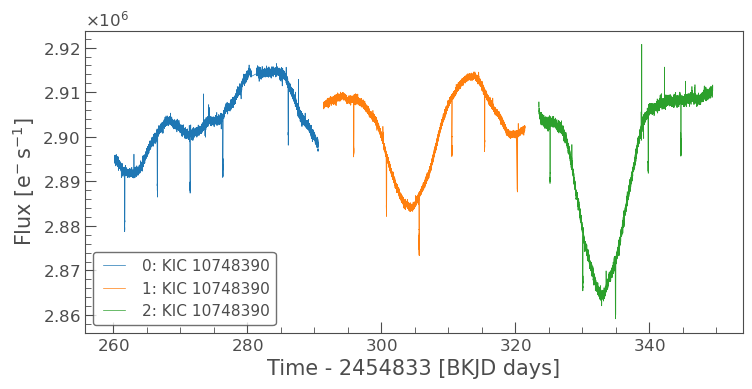

In [6]:
lc['lc_q3'].plot()

In [7]:
all_lc = lc_collection.stitch()
all_lc = all_lc.remove_nans().remove_outliers()
# Require non-zero quality flags
all_lc = all_lc[all_lc.quality == 0]

In [8]:
period = np.linspace(2, 20, 10000)
bls = all_lc.to_periodogram(method='bls', period=period, frequency_factor=500);
planet_period = bls.period_at_max_power
planet_t0 = bls.transit_time_at_max_power
planet_dur = bls.duration_at_max_power

In [9]:
planet_t0

<Time object: scale='tdb' format='bkjd' value=124.85859840558085>

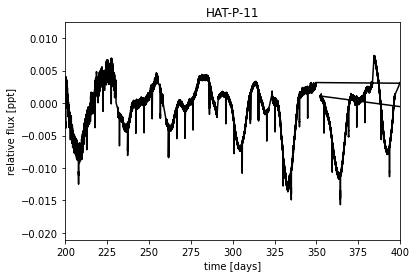

In [10]:
# Make sure that the data type is consistent
x = np.ascontiguousarray(all_lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(all_lc.flux, dtype=np.float64)


# Normalize around zero for GP fitting.  Keep in units of relative flux, rather than say ppt.
mu = np.nanmedian(y)
y = y / mu - 1

plt.plot(x, y, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.xlim([200, 400])
plt.title("HAT-P-11")
plt.show()

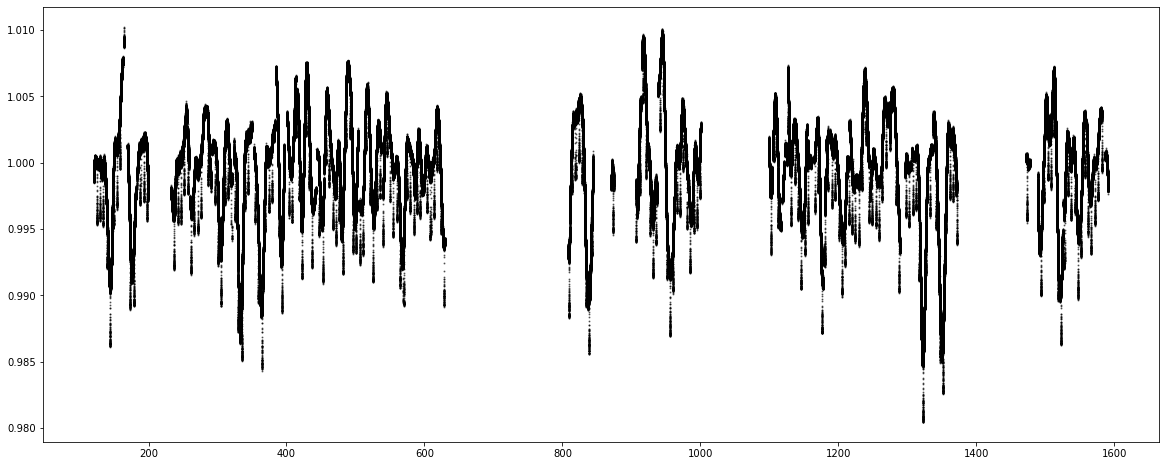

In [11]:
all_lc.flux.value[88000:129000] = np.nan
all_lc.flux.value[615000:690000] = np.nan
all_lc = all_lc.remove_nans()
tranmask = all_lc.create_transit_mask(transit_time=planet_t0.value, period=np.float64(planet_period), duration=np.float64(planet_dur))
plt.figure(figsize=(20, 8))
plt.plot(all_lc.time.value,all_lc.flux, "k.", ms=2, alpha=0.5)

In [55]:
x = all_lc.time.value
x = np.sort(x)

y = all_lc.flux.value[np.argsort(x)]
yerr = all_lc.flux_err

threshold = 1.
lc_chunks_times = np.split(x, np.where(np.diff(x) > threshold)[0]+1)
lc_chunks_fluxes = np.split(y, np.where(np.diff(x) > threshold)[0]+1)
lc_chunks_err = np.split(yerr, np.where(np.diff(x) > threshold)[0]+1)

In [13]:
lc_chunks_err[0]

<MaskedQuantity [0.00017174, 0.00015709, 0.00015296, ..., 0.00014417,
                 0.00014598, 0.00014794]>

In [14]:
len(lc_chunks_times[-1])

5637

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_18001/4294466071.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,5))


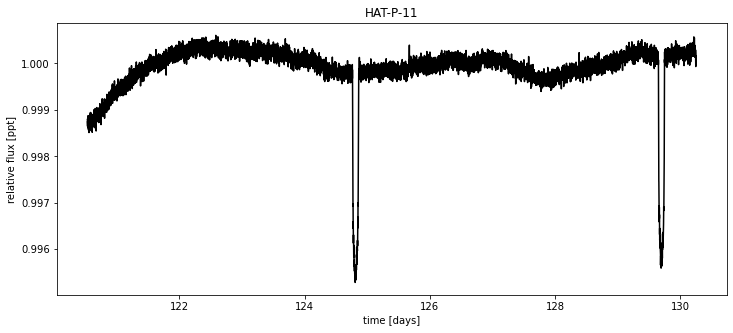

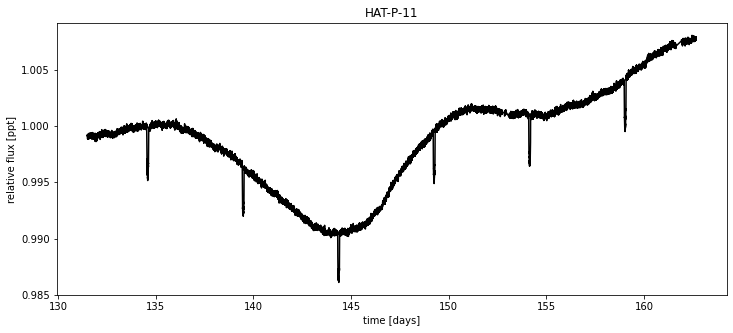

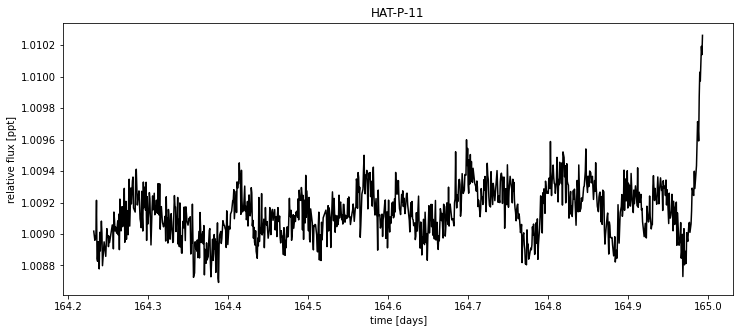

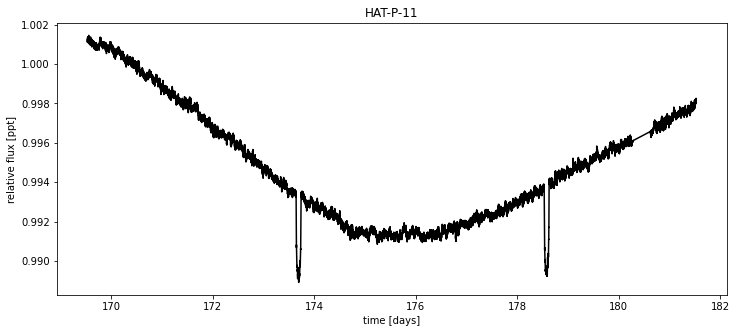

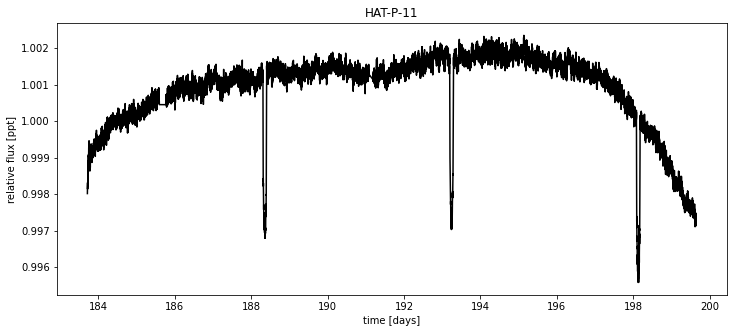

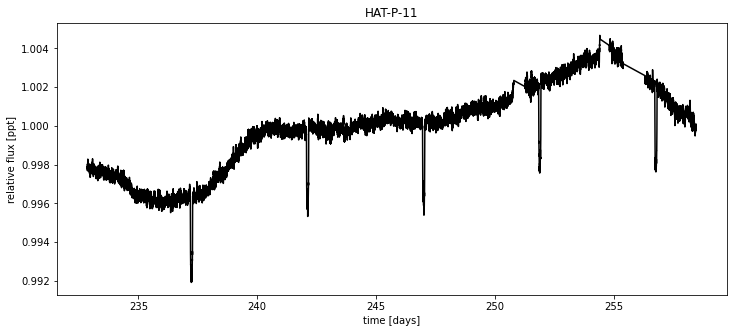

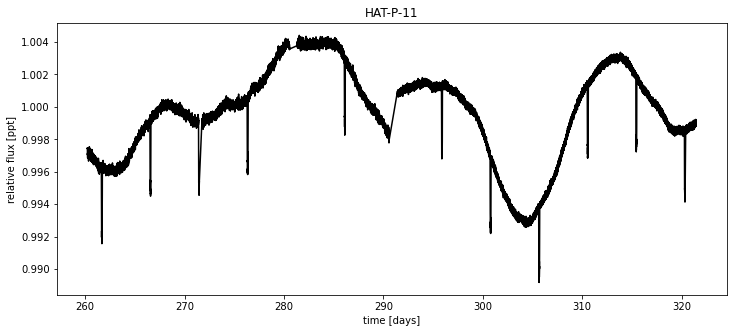

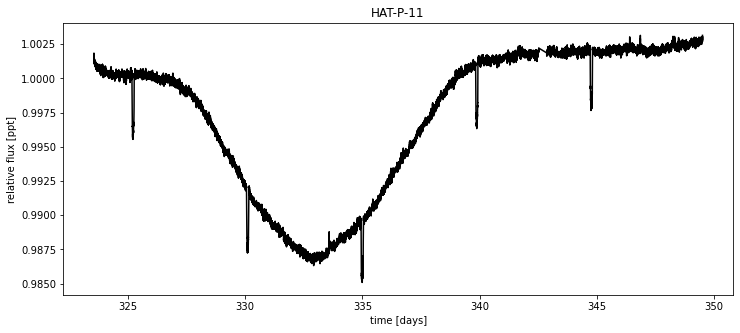

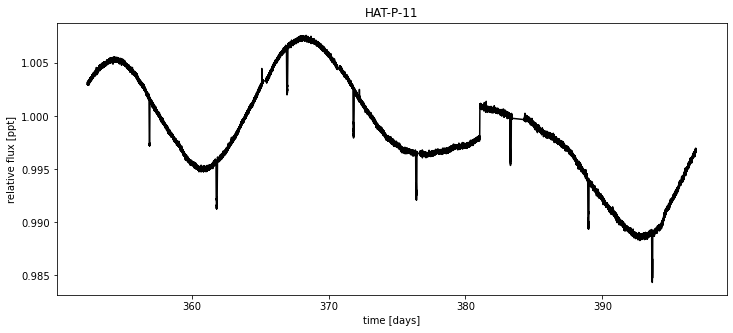

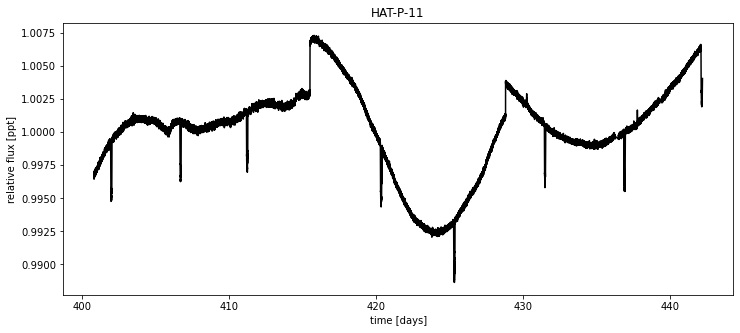

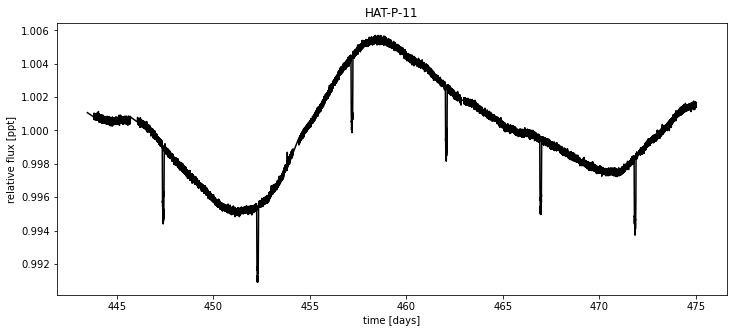

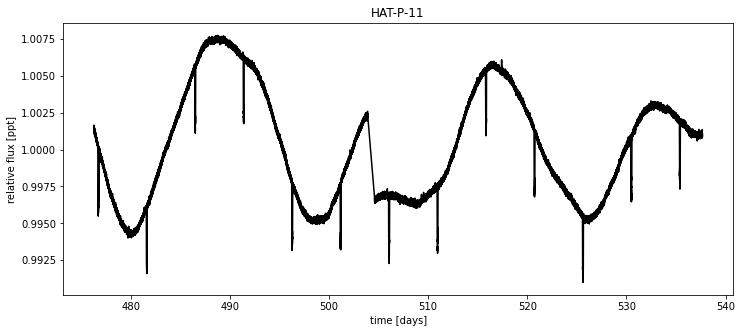

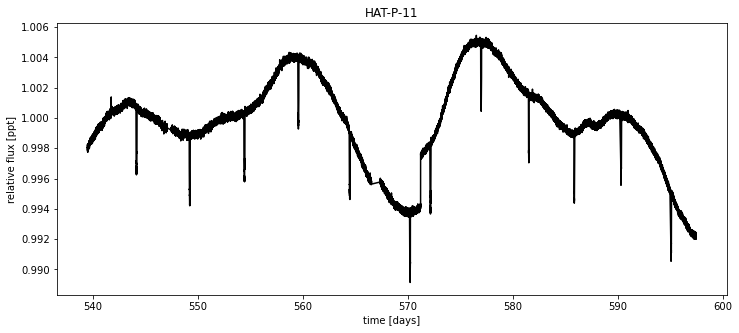

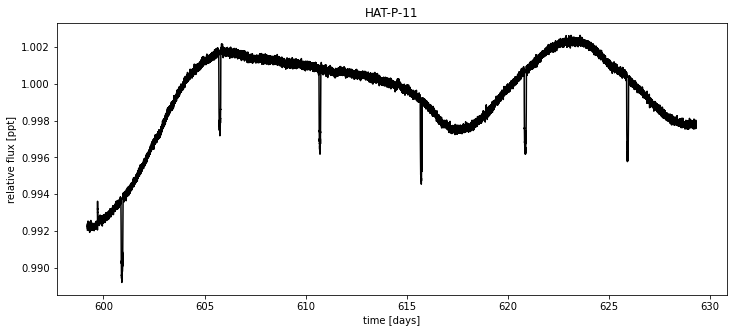

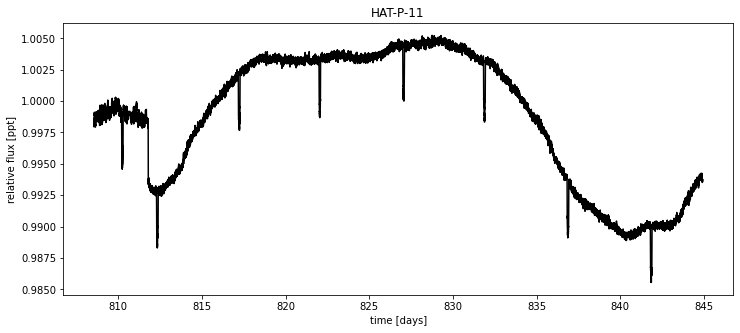

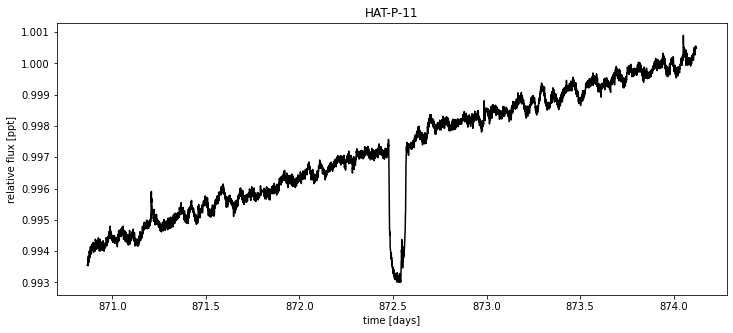

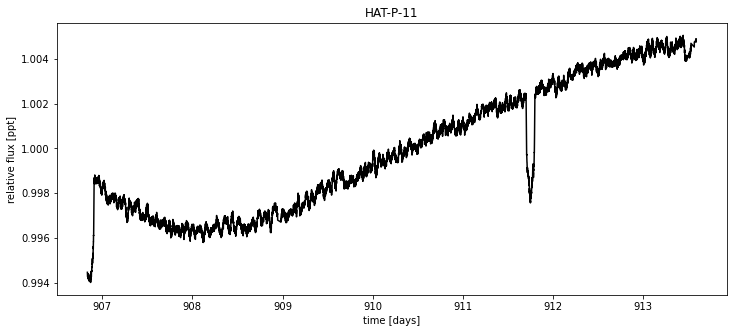

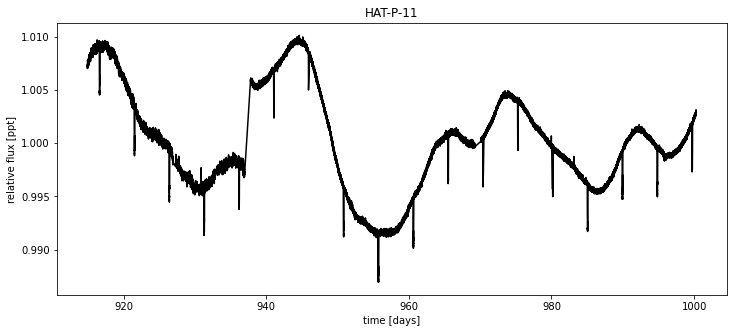

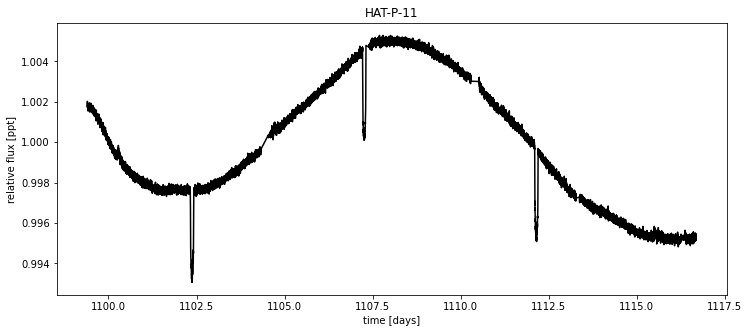

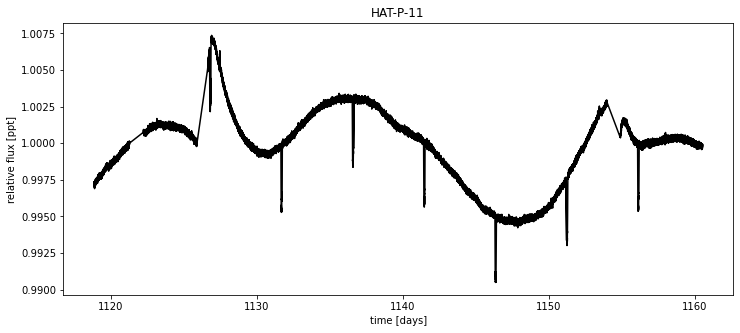

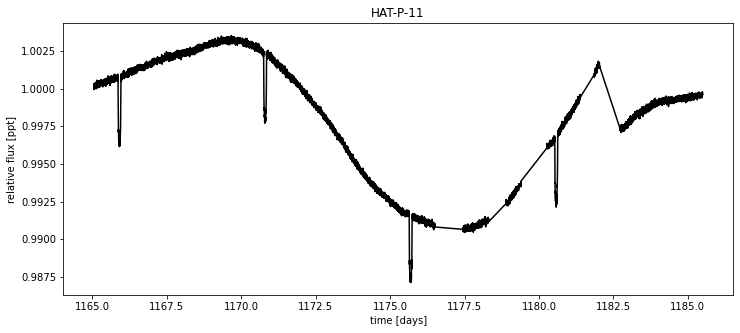

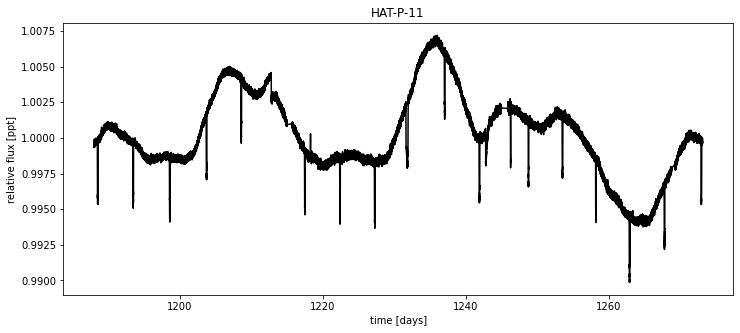

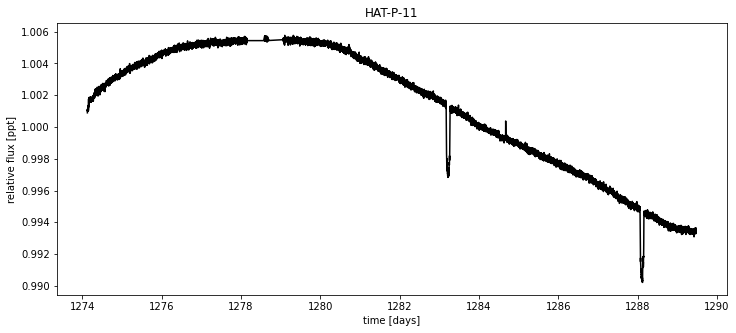

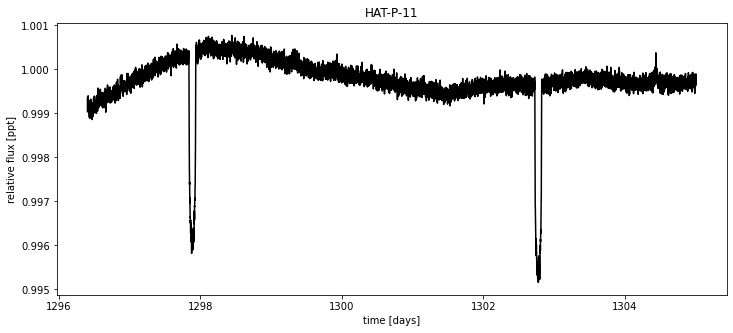

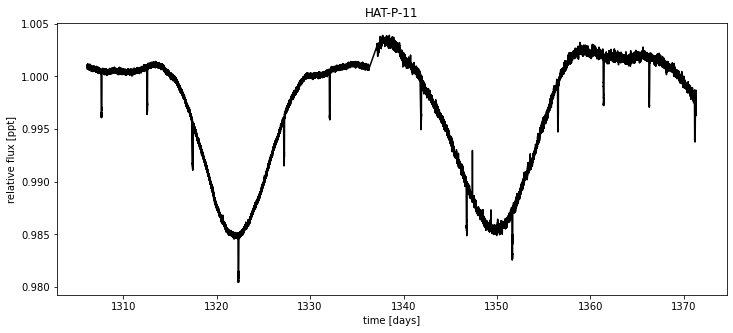

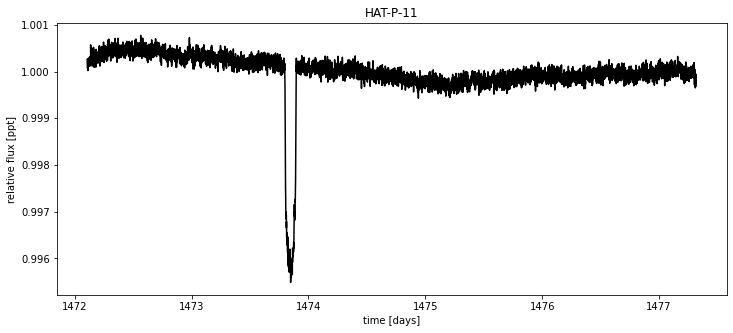

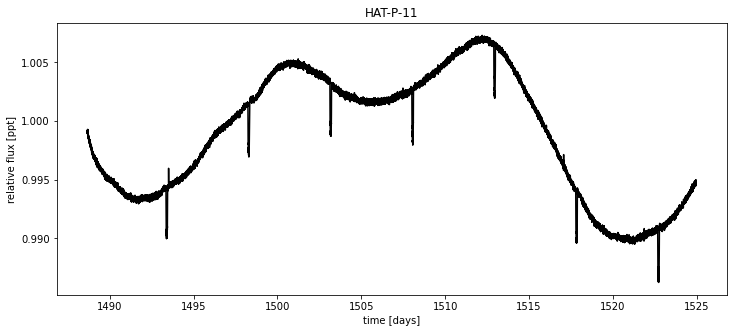

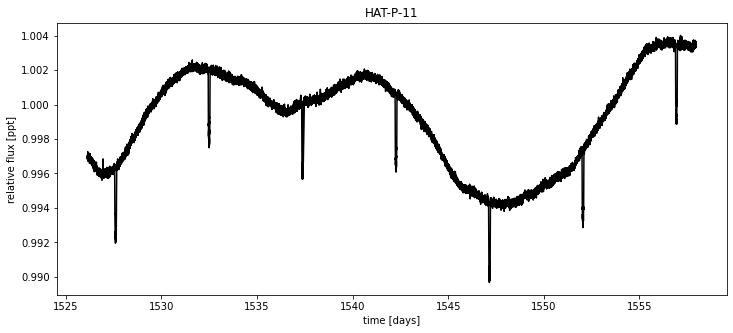

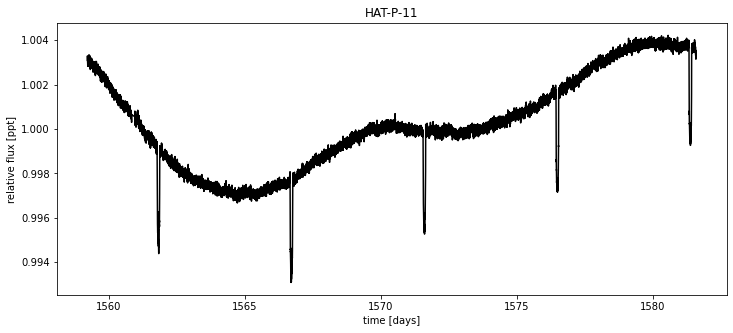

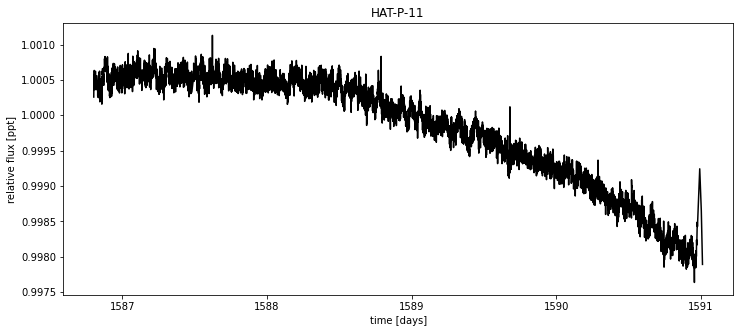

In [56]:
for chunk in range(len(lc_chunks_times)):
    x = lc_chunks_times[chunk].copy()
    y = lc_chunks_fluxes[chunk].copy()
    yerr = lc_chunks_err[chunk].copy()


    plt.figure(figsize=(12,5))
    plt.plot(x, y, "k")
    # plt.xlim(x.min(), x.max())
    plt.xlabel("time [days]")
    plt.ylabel("relative flux [ppt]")
    _ = plt.title("HAT-P-11")

In [17]:
np.diff(x)

array([0.00204348, 0.00068123, 0.00068113, ..., 0.01430399, 0.01089827,
       0.00817368])

(0.0, 2.2)

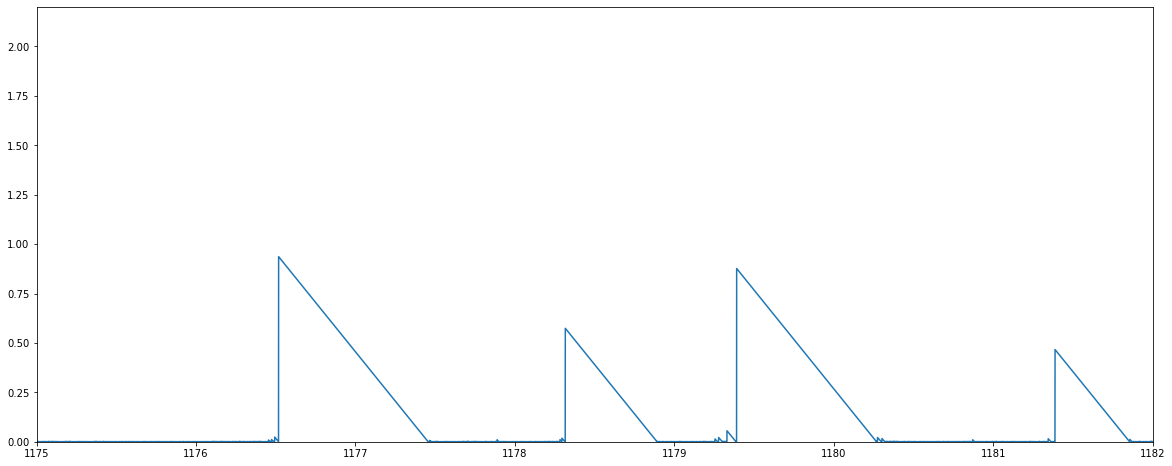

In [54]:
x = all_lc.time.value
x = np.sort(x)

y = all_lc.flux.value[np.argsort(x)]
yerr = all_lc.flux_err

plt.figure(figsize=(20, 8))
plt.plot(x[:-1], np.diff(x))
plt.xlim(1175,1182)
plt.ylim(0.0,2.2)

In [67]:
def transit_gp_bychunks(lightcurve, start=None):
    starry.config.lazy = True
    
    threshold = 1.

    x = lightcurve.time.value
    y = lightcurve.flux.value

    x = np.sort(x)
    y = y[np.argsort(x)]

    yerr = lightcurve.flux_err.value
    # mu = np.median(y)
    # y = (y / mu - 1) * 1e3
    # yerr = yerr * 1e3 / mu

    lc_chunks_times = np.split(x, np.where(np.diff(x) > threshold)[0]+1)
    lc_chunks_fluxes = np.split(y, np.where(np.diff(x) > threshold)[0]+1)
    lc_chunks_err = np.split(yerr, np.where(np.diff(x) > threshold)[0]+1)

    # plt.figure(figsize=(12,5))
    # plt.plot(x, y, "k")
    # # plt.xlim(x.min(), x.max())
    # plt.xlabel("time [days]")
    # plt.ylabel("relative flux [ppt]")
    # _ = plt.title("HAT-P-11")

    with pm.Model() as model:
        # Shared parameters
        mean = pm.Normal("mean", mu=0.0, sd=10, testval=0)

        # porb = pm.Uniform("porb", lower=4,upper=5, testval=4.888)
        # t0 = pm.Uniform("t0", lower=124,upper=125, testval=124.85) 
        # Orbital parameters for the planet.
        porb = pm.Normal("porb", mu=4.888, sigma=0.001) #lower=4,upper=5, testval=4.888)
        t0 = pm.Normal("t0", mu=124.85, sigma=0.01) #lower=124,upper=125, testval=124.85)
        u1 = pm.Uniform("u1", lower=0.638,upper=0.7)
        u2 = pm.Uniform("u2", lower=0.033,upper=0.05) 
        rp = pm.Uniform("rp", lower=0.03232321,upper=0.04632)

        # Instantiate the star; all its parameters are assumed
        # to be known exactly, ecept for the limb-darkening coefficients
        A = starry.Primary(
            starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0
        )
        A.map[1] = u1
        A.map[2] = u2

        # Instantiate the planet. Everything is fixed except for
        # its luminosity and the hot spot offset.
        b = starry.Secondary(
            starry.Map(ydeg=1, udeg=0, amp=0, obl=0.0),
            m=7.0257708e-5,  # mass in solar masses
            r=rp,  # radius in solar radii
            inc=88.99, # orbital inclination
            porb=porb,  # orbital period in days
            prot=1,
            w=-162.149,  # Argument of periastron (little omega)
            ecc=0.265,  # eccentricity
            Omega=106,
            t0=t0,
        )

         # A term to describe the non-periodic variability
        sigma = pm.InverseGamma(
            "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        rho = pm.InverseGamma(
            "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
        )

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period = pm.Normal("log_period", mu=np.log(36.53), sigma=2.0)
        prot = pm.Deterministic("prot", tt.exp(log_period))
        log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
        log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
        f = pm.Uniform("f", lower=0.1, upper=1.0)

        for chunk in range(len(lc_chunks_times)):
            x = lc_chunks_times[chunk].copy()
            y = lc_chunks_fluxes[chunk].copy()
            yerr = lc_chunks_err[chunk].copy()

            mu = np.median(y)
            y = (y / mu - 1) * 1e3
            yerr = yerr * 1e3 / mu


            plt.figure(figsize=(12,5))
            plt.plot(x, y, "k")
            # plt.xlim(x.min(), x.max())
            plt.xlabel("time [days]")
            plt.ylabel("relative flux [ppt]")
            _ = plt.title("HAT-P-11")


            # Instantiate the system as before
            sys = starry.System(A, b)

            # Our model for the flux in ppt
            flux_model = pm.Deterministic(f"flux_model_{chunk}", (sys.flux(x) - 1) * 1e3)


            # Use the GP model from the stellar variability tutorial 

            # A jitter term describing excess white noise
            log_jitter = pm.Normal(f"log_jitter_{chunk}", mu=np.log(np.mean(yerr)), sigma=2.0)


            # Set up the Gaussian Process model
            kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
            kernel += terms.RotationTerm(
                sigma=sigma_rot,
                period=prot,
                Q0=tt.exp(log_Q0),
                dQ=tt.exp(log_dQ),
                f=f,
            )
            gp = GaussianProcess(
                kernel,
                t=x,
                diag=yerr**2 + tt.exp(2 * log_jitter),
                mean=mean,
                quiet=True,
            )

            # Compute the Gaussian Process likelihood and add it into the
            # the PyMC3 model as a "potential"
            # gp.marginal("gp", observed=y)
            gp.marginal(f"gp_{chunk}", observed=y-flux_model)

            # Compute the GP model prediction for plotting purposes
            # pm.Deterministic("gp_pred", gp.predict(y))
            pm.Deterministic(f"gp_pred_{chunk}",gp.predict(y-flux_model))


        # Optimize the MAP solution.
        # if start is None:
        #     start = model.test_point

        # map_soln = start

        # map_soln = pmx.optimize(
        #     start=map_soln, vars=[sigma_rot, f, prot, log_Q0, log_dQ]
        # )
        # map_soln = pmx.optimize(
        #     start=map_soln,
        #     vars=[
        #         t0,
        #         porb,
        #         mean,
        #         u1,
        #         u2,
        #         rp,
        #     ],
        # )
        map_soln = pmx.optimize()#start=map_soln)
            
    return model,map_soln

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x1c0e7e2c0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x1c0e7e2c0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x1c0e7e2c0>.1
WARNING 

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{or_,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.op

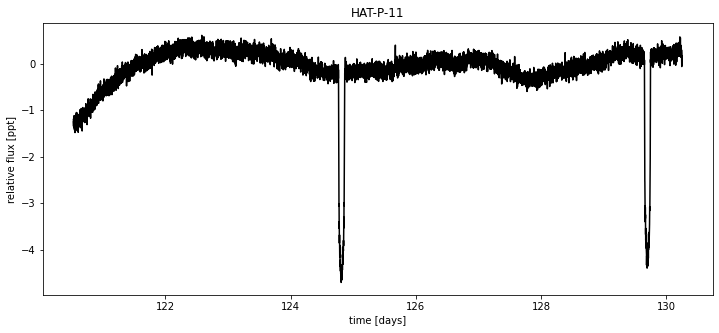

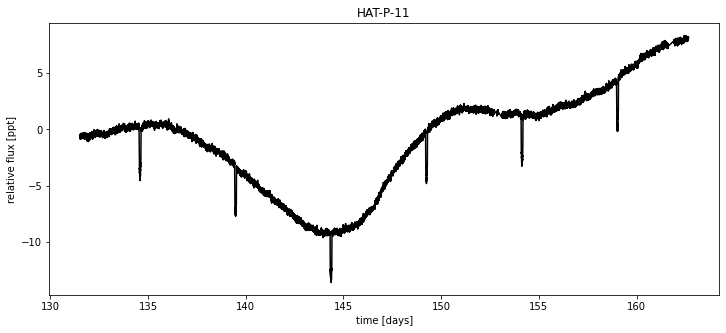

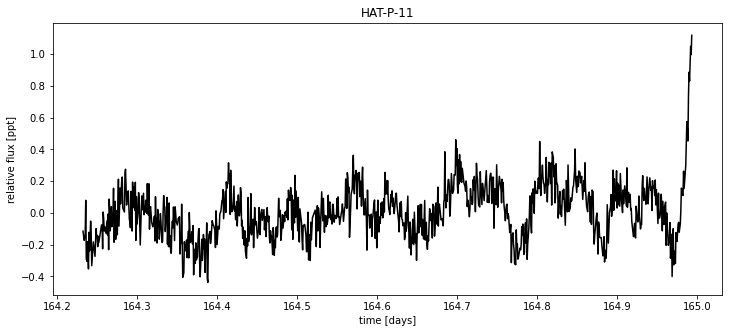

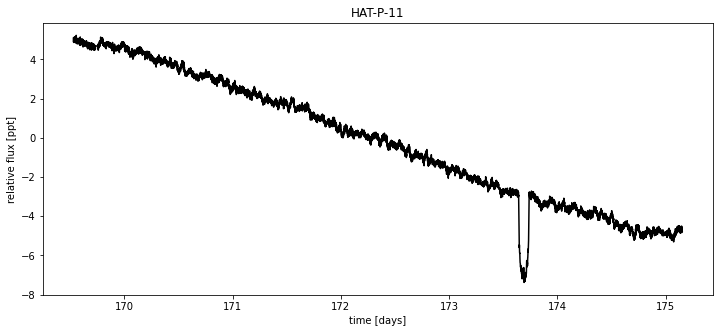

In [70]:
model,map_soln = transit_gp_bychunks(all_lc[:60000], start=None)

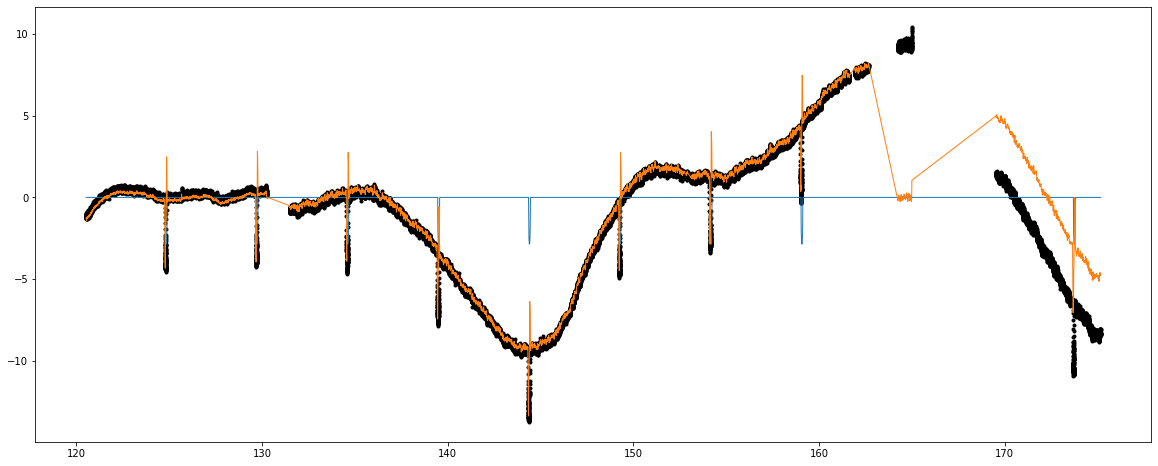

In [72]:
x = all_lc[:60000].time.value
y = all_lc[:60000].flux.value

x = np.sort(x)
y = y[np.argsort(x)]

yerr = all_lc.flux_err.value
yerr = yerr[np.argsort(x)]

mu = np.median(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

gp_mod = np.concatenate((map_soln['gp_pred_0'],map_soln['gp_pred_1'],map_soln['gp_pred_2'],map_soln['gp_pred_3']))
transit_mod = np.concatenate((map_soln['flux_model_0'],map_soln['flux_model_1'],map_soln['flux_model_2'],map_soln['flux_model_3'])) 

plt.figure(figsize=(20,8))
plt.plot(x, y, 'k.')
plt.plot(x, transit_mod, "C0-", lw=1)
plt.plot(x, gp_mod, "C1-", lw=1)

In [7]:
tranmask = all_lc.create_transit_mask(transit_time=planet_t0.value, period=np.float64(planet_period), duration=np.float64(planet_dur))

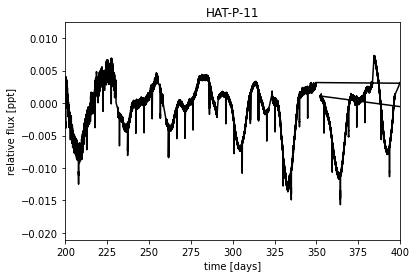

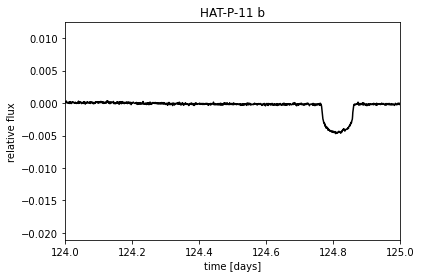

In [9]:
plt.plot(x, y, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.xlim([200, 400])
plt.title("HAT-P-11")
plt.show()

plt.plot(x, y, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.xlim([124, 125])  # transit is here
# plt.ylim([-30e-3, -5e-3])
plt.title("HAT-P-11 b")
plt.show()

## Cleaning the data:

In [10]:
clean_mask = (all_lc.time.value >= 201) & (all_lc.time.value <=231) & (all_lc.time.value >= 847) & (all_lc.time.value <=905) & (all_lc.time.value >= 1337) & (all_lc.time.value <=1372) 

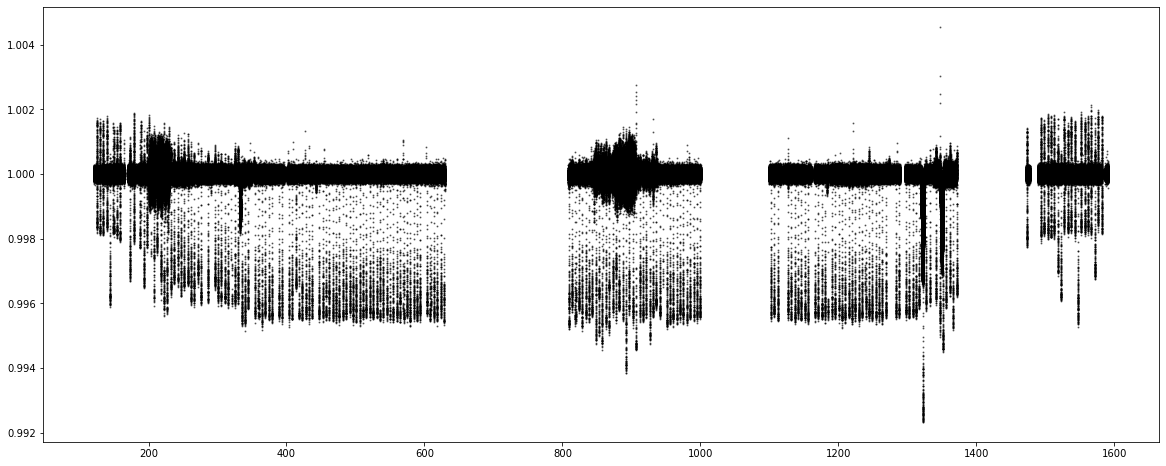

In [11]:
tmp = np.array(all_lc.flatten(mask=tranmask).flux)
tmpt = all_lc.time.value
plt.figure(figsize=(20, 8))
plt.plot(tmpt, tmp, "k.", ms=2, alpha=0.5)

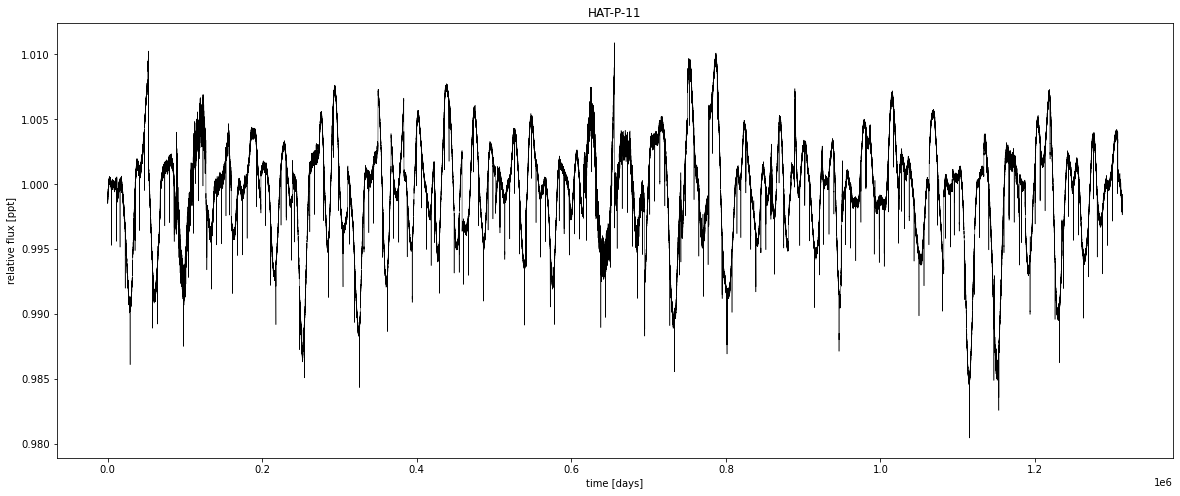

In [12]:
x = np.ascontiguousarray(all_lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(all_lc.flux, dtype=np.float64)


plt.figure(figsize=(20, 8))
plt.plot(y, "k", lw=0.5)
# plt.xlim(200, 230)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("HAT-P-11")
plt.show()

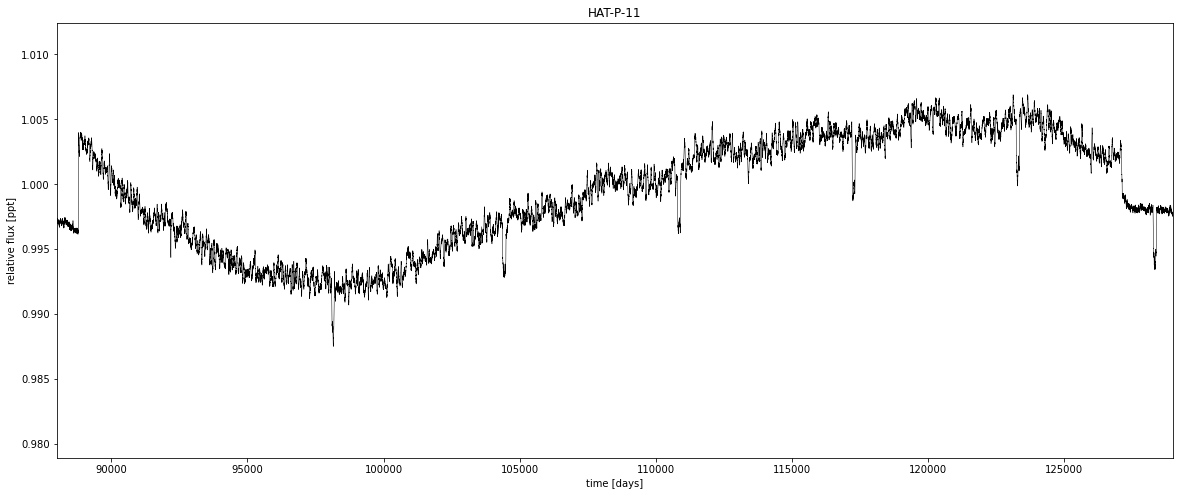

In [13]:
x = np.ascontiguousarray(all_lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(all_lc.flux, dtype=np.float64)


plt.figure(figsize=(20, 8))
plt.plot(y, "k", lw=0.5)
plt.xlim(88000, 129000)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("HAT-P-11")
plt.show()

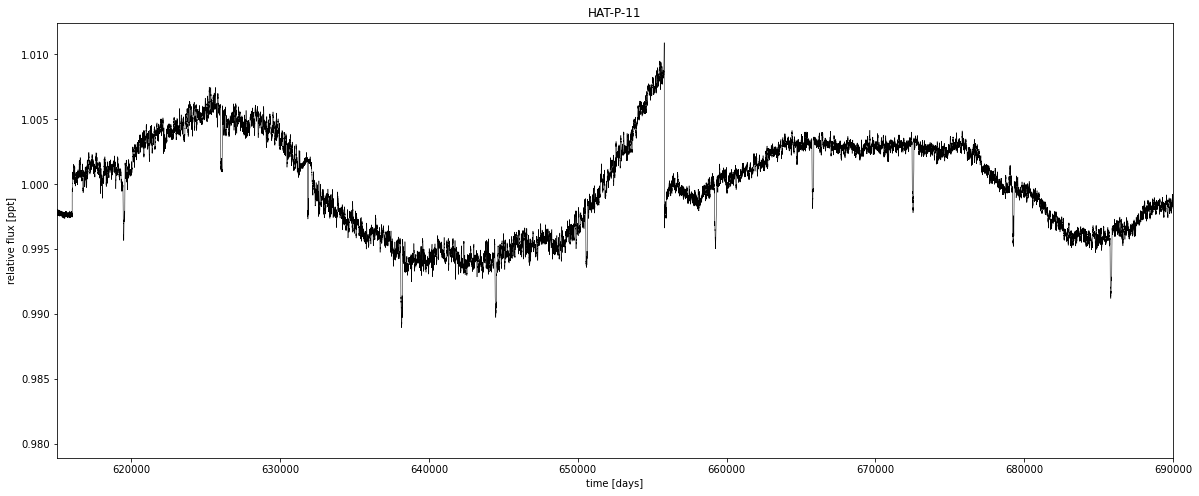

In [14]:
x = np.ascontiguousarray(all_lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(all_lc.flux, dtype=np.float64)


plt.figure(figsize=(20, 8))
plt.plot(y, "k", lw=0.5)
plt.xlim(615000,690000)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("HAT-P-11")
plt.show()

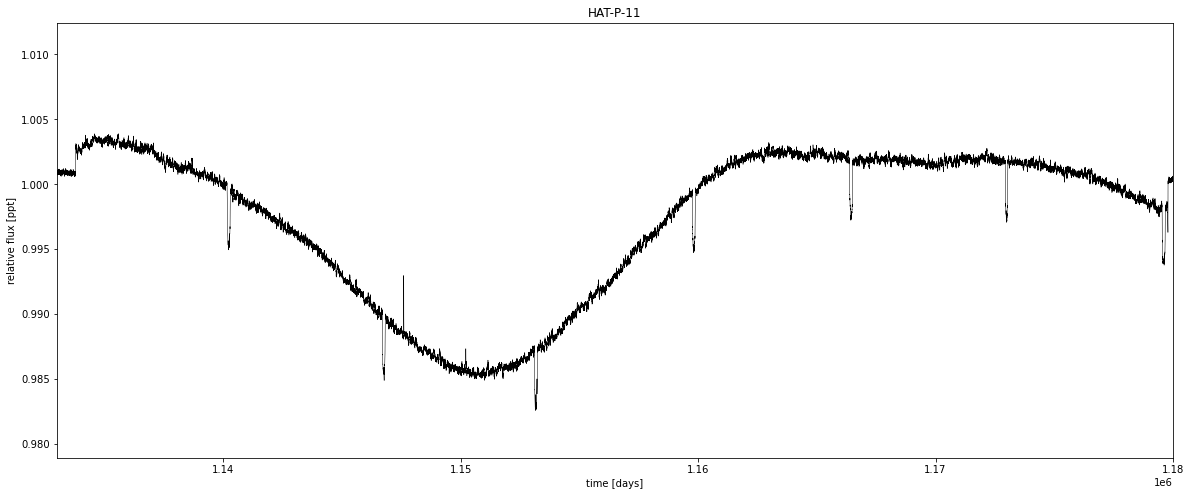

In [15]:
x = np.ascontiguousarray(all_lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(all_lc.flux, dtype=np.float64)


plt.figure(figsize=(20, 8))
plt.plot(y, "k", lw=0.5)
plt.xlim(1133000,1180000)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("HAT-P-11")
plt.show()

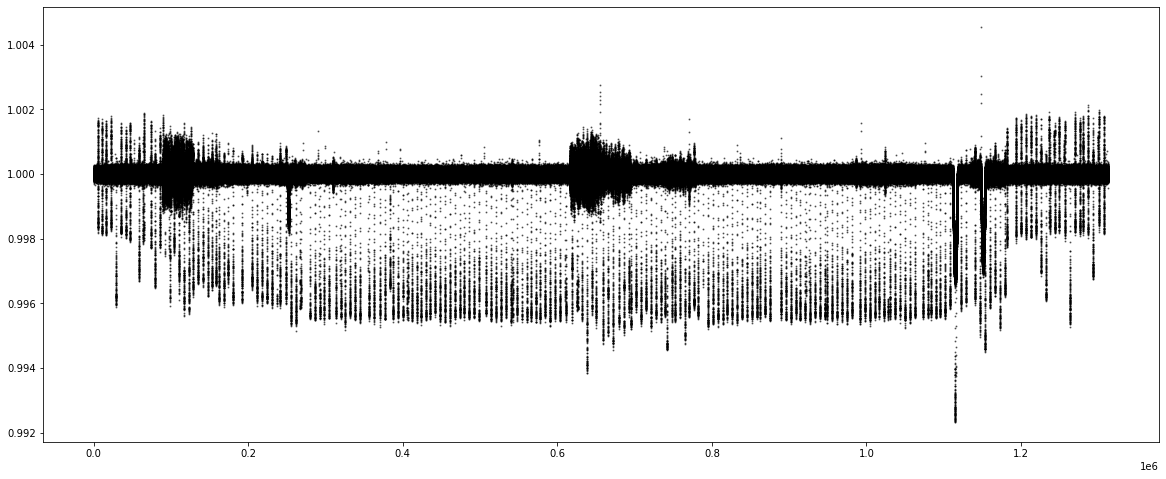

In [16]:
plt.figure(figsize=(20, 8))
plt.plot(tmp, "k.", ms=2, alpha=0.5)

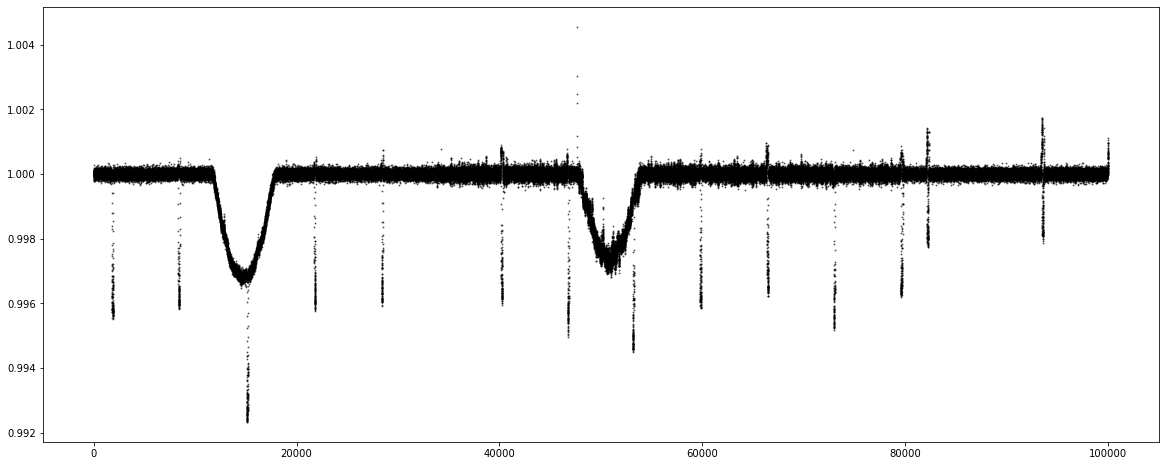

In [17]:
plt.figure(figsize=(20, 8))
plt.plot(tmp[1100000:1200000], "k.", ms=2, alpha=0.5)

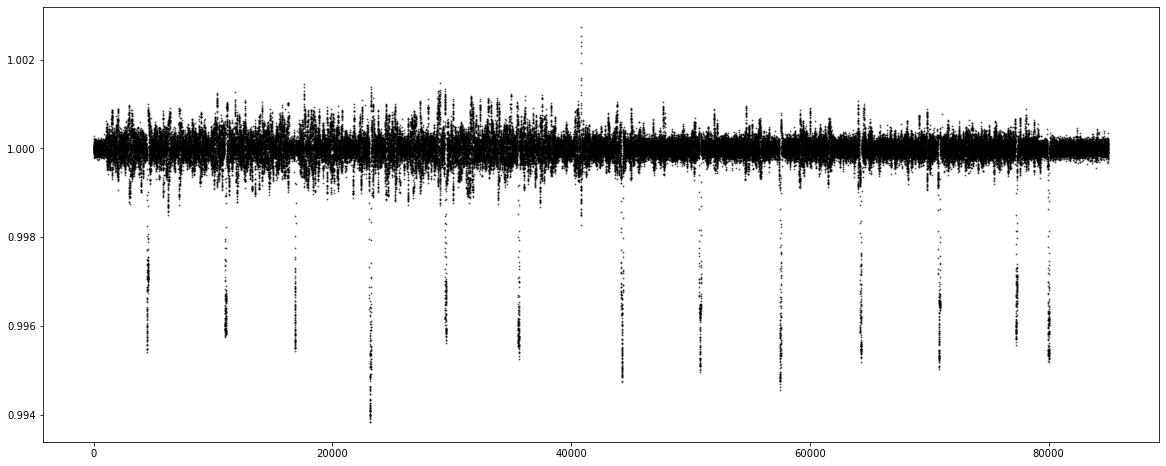

In [18]:
plt.figure(figsize=(20, 8))
plt.plot(tmp[615000:700000], "k.", ms=2, alpha=0.5)

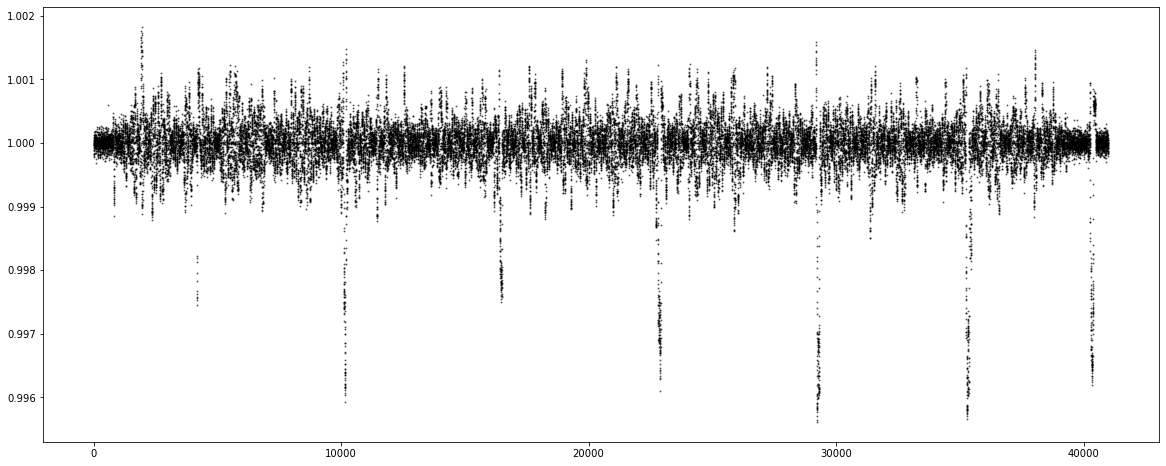

In [19]:
plt.figure(figsize=(20, 8))
plt.plot(tmp[88000:129000], "k.", ms=2, alpha=0.5)

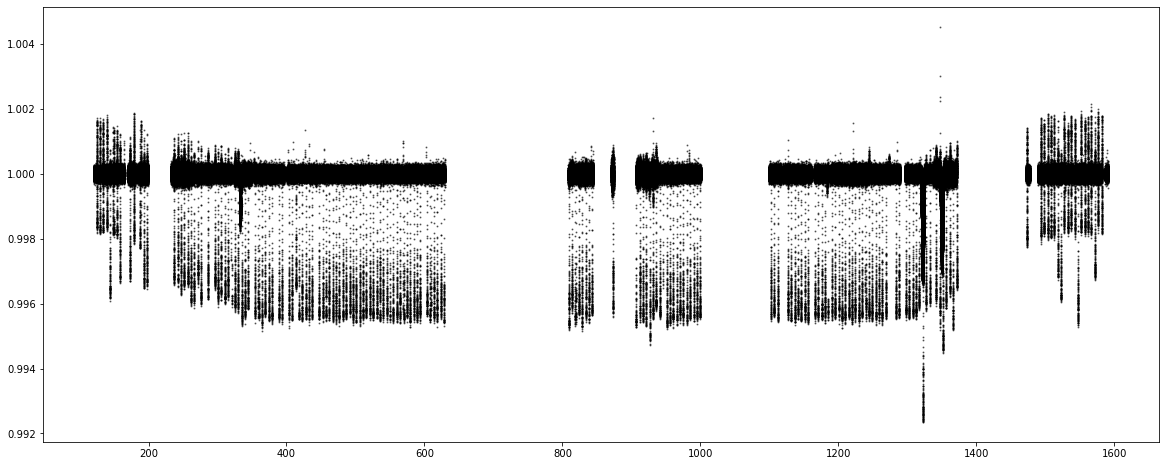

In [20]:
lc_temp = all_lc.copy()
lc_temp.flux.value[88000:129000] = np.nan
lc_temp.flux.value[615000:690000] = np.nan
lc_temp = lc_temp.remove_nans()
# lc_temp.flux.value[300000:500000] = np.nan
# lc_temp = lc_temp.remove_nans()
# lc_temp.flux.value[610000:] = np.nan
# lc_temp = lc_temp.remove_nans()
# lc_temp.flux.value[:30000] = np.nan
# lc_temp = lc_temp.remove_nans()
tranmask = lc_temp.create_transit_mask(transit_time=planet_t0.value, period=np.float64(planet_period), duration=np.float64(planet_dur))
plt.figure(figsize=(20, 8))
plt.plot(lc_temp.time.value,lc_temp.flatten(mask=tranmask).flux, "k.", ms=2, alpha=0.5)
# plt.xlim(251,253)

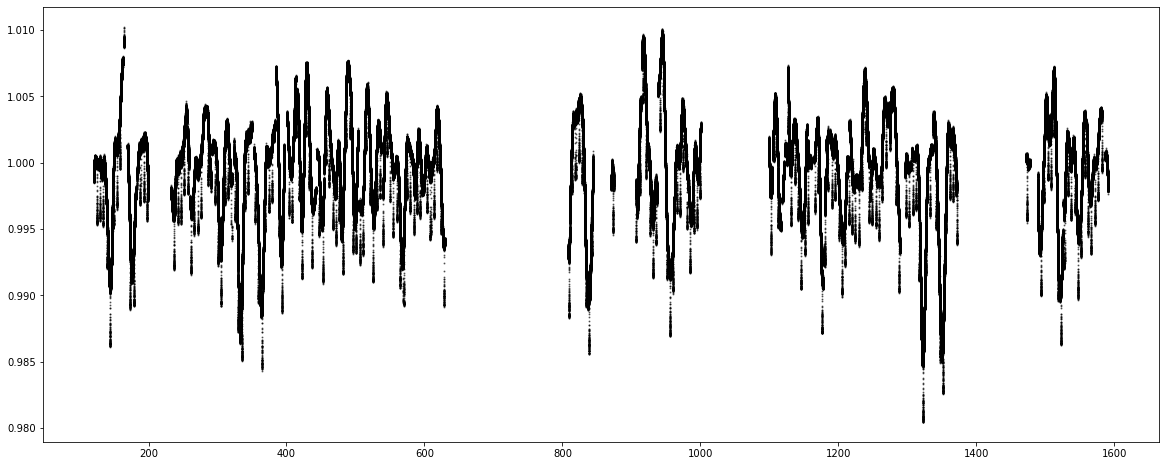

In [21]:
all_lc.flux.value[88000:129000] = np.nan
all_lc.flux.value[615000:690000] = np.nan
all_lc = all_lc.remove_nans()
tranmask = all_lc.create_transit_mask(transit_time=planet_t0.value, period=np.float64(planet_period), duration=np.float64(planet_dur))
plt.figure(figsize=(20, 8))
plt.plot(all_lc.time.value,all_lc.flux, "k.", ms=2, alpha=0.5)
# plt.xlim(251,253)

The $\texttt{starry}$ parameters:

In [22]:
star = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0)
trueu1 = 0.646
trueu2 = 0.048
star.map[1] = trueu1
star.map[2] = trueu2

In [23]:
# These are the parameters we're going to try to infer
truerp = 0.039974684
trueperiod = planet_period
truet0 = planet_t0.value

planet_b = starry.Secondary(
    starry.Map(ydeg=1, udeg=0, amp=0.0),
    m=7.0257708e-5,  # mass in solar masses
    r=truerp,  # radius in solar radii
    inc=88.99, # orbital inclination
    porb=trueperiod,  # orbital period in days
    prot=1,
    w=-162.149,  # Argument of periastron (little omega)
    ecc=0.265,  # eccentricity
    Omega=106, # I think it's lambda in Morris 2017
    t0=truet0,
)

Pre-computing some matrices... Done.


In [24]:
x = np.ascontiguousarray(all_lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(all_lc.flux, dtype=np.float64)


x = np.sort(x)
y = y[np.argsort(x)]
print(y)
yerr = np.ascontiguousarray(all_lc.flux_err, dtype=np.float64)
print(yerr)
mu = np.mean(y)
y = (y / mu - 1) *1e3
yerr = yerr * 1e3 / mu
print(yerr)
print(y)

[0.99879408 0.99873668 0.99864805 ... 0.99924296 0.99865025 0.99789053]
[1.71740816e-04 1.57088565e-04 1.52962835e-04 ... 9.05502457e-05
 8.71840093e-05 8.26131218e-05]
[0.17184969 0.15718815 0.15305981 ... 0.09060765 0.08723928 0.0826655 ]
[-0.57271793 -0.63015359 -0.71884189 ... -0.12355077 -0.71663512
 -1.47683756]


Let's try the simultanious transit and GP model

In [75]:
def transit_gp(lightcurve,start=None):
    starry.config.lazy = True
    
    x = np.ascontiguousarray(lightcurve.time.value, dtype=np.float64)
    y = np.ascontiguousarray(lightcurve.flux, dtype=np.float64)

    x = np.sort(x)
    y = y[np.argsort(x)]
    
    yerr = np.ascontiguousarray(lightcurve.flux_err, dtype=np.float64)
    mu = np.median(y)
    y = (y / mu - 1) * 1e3
    yerr = yerr * 1e3 / mu

    plt.figure(figsize=(12,5))
    plt.plot(x, y, "k")
    # plt.xlim(x.min(), x.max())
    plt.xlabel("time [days]")
    plt.ylabel("relative flux [ppt]")
    _ = plt.title("HAT-P-11")

    with pm.Model() as model:
        # Shared parameters
        mean = pm.Normal("mean", mu=0.0, sd=10, testval=0)

        # porb = pm.Uniform("porb", lower=4,upper=5, testval=4.888)
        # t0 = pm.Uniform("t0", lower=124,upper=125, testval=124.85) 
        # Orbital parameters for the planet.
        porb = pm.Normal("porb", mu=4.888, sigma=0.001) #lower=4,upper=5, testval=4.888)
        t0 = pm.Normal("t0", mu=124.85, sigma=0.01) #lower=124,upper=125, testval=124.85)
        u1 = pm.Uniform("u1", lower=0.638,upper=0.7)
        u2 = pm.Uniform("u2", lower=0.033,upper=0.05) 
        rp = pm.Uniform("rp", lower=0.03232321,upper=0.04632)

        # Instantiate the star; all its parameters are assumed
        # to be known exactly, ecept for the limb-darkening coefficients
        A = starry.Primary(
            starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0
        )
        A.map[1] = u1
        A.map[2] = u2

        # Instantiate the planet. Everything is fixed except for
        # its luminosity and the hot spot offset.
        b = starry.Secondary(
            starry.Map(ydeg=1, udeg=0, amp=0, obl=0.0),
            m=7.0257708e-5,  # mass in solar masses
            r=rp,  # radius in solar radii
            inc=88.99, # orbital inclination
            porb=porb,  # orbital period in days
            prot=1,
            w=-162.149,  # Argument of periastron (little omega)
            ecc=0.265,  # eccentricity
            Omega=106,
            t0=t0,
        )

        # Instantiate the system as before
        sys = starry.System(A, b)

        # Our model for the flux in ppt
        flux_model = pm.Deterministic("flux_model", (sys.flux(x) - 1) * 1e3)


        # transit_model = mean + tt.sum(
        #     sys.flux(x),
        #     axis=-1,
        # )

        # Convenience function for plotting.
        # pm.Deterministic(
        #     "transit_pred",
        #     sys.flux(x),
        # )

        # Use the GP model from the stellar variability tutorial 

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

        # A term to describe the non-periodic variability
        sigma = pm.InverseGamma(
            "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        rho = pm.InverseGamma(
            "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
        )

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period = pm.Normal("log_period", mu=np.log(36.53), sigma=2.0)
        prot = pm.Deterministic("prot", tt.exp(log_period))
        log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
        log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
        f = pm.Uniform("f", lower=0.1, upper=1.0)

        # Set up the Gaussian Process model
        kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
        kernel += terms.RotationTerm(
            sigma=sigma_rot,
            period=prot,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        gp = GaussianProcess(
            kernel,
            t=x,
            diag=yerr**2 + tt.exp(2 * log_jitter),
            mean=mean,
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        # gp.marginal("gp", observed=y)
        gp.marginal("gp", observed=y-flux_model)

        # Compute the GP model prediction for plotting purposes
        # pm.Deterministic("gp_pred", gp.predict(y))
        pm.Deterministic("gp_pred",gp.predict(y-flux_model))


        # Optimize the MAP solution.
        if start is None:
            start = model.test_point

        map_soln = start

        map_soln = pmx.optimize(
            start=map_soln, vars=[sigma_rot, f, prot, log_Q0, log_dQ]
        )
        map_soln = pmx.optimize(
            start=map_soln,
            vars=[
                t0,
                porb,
                mean,
                u1,
                u2,
                rp,
            ],
        )
        map_soln = pmx.optimize(start=map_soln)
    return model, map_soln, x, y

In [76]:
model,map_soln,x,y = transit_gp(all_lc)

optimizing logp for variables: [log_dQ, log_Q0, log_period, f, sigma_rot]


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x19a123df0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x19a123df0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [rp, u2, u1, mean, porb, t0]


In [88]:
with model:
    transit_model_guess = pmx.eval_in_model(model.flux_model, point=model.test_point)

(575.0, 630.0)

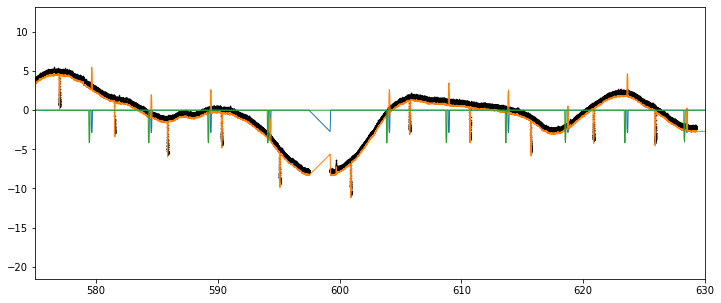

In [118]:
# Rodrigo
plt.figure(figsize=(12,5))
plt.plot(x, y, "k.", ms=1)

gp_mod = map_soln['gp_pred']+map_soln['mean']
transit_mod = map_soln['flux_model']

plt.plot(x, transit_mod, "C0-", lw=1)
plt.plot(x, gp_mod, "C1-", lw=1)

plt.plot(x, transit_model_guess, "C2-", lw=1)

#plt.xlim(233, 243)
#plt.ylim(-10, 2)


plt.xlim(575, 630)

In [132]:
chunk1 = (x>=575) & (x<=630)
y[chunk1]

array([ 4.02839715,  4.08752608,  4.03185428, ..., -2.22824294,
       -2.08620236, -2.1794258 ])

optimizing logp for variables: [log_dQ, log_Q0, log_period, f, sigma_rot]


message: Optimization terminated successfully.
logp: 40418.428517038294 -> 40423.107178088554
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x190557790>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x190557790>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [rp, u2, u1, mean, porb, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: 40423.107178088554 -> 45324.43942667167
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x190557790>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x190557790>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [f, log_dQ, log_Q0, log_period, 

message: Desired error not necessarily achieved due to precision loss.
logp: 45324.43942667167 -> 55377.58631888086


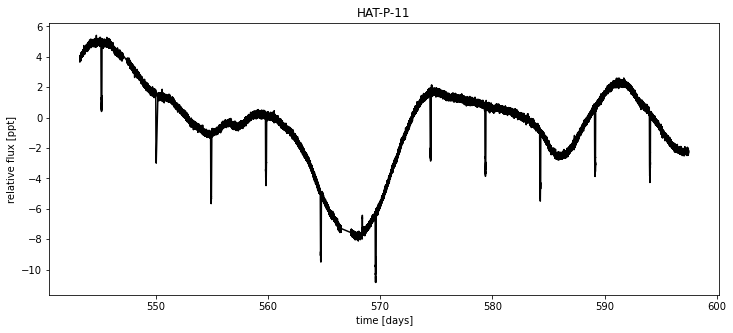

In [136]:
model,map_soln,x,y = transit_gp(all_lc[chunk1])

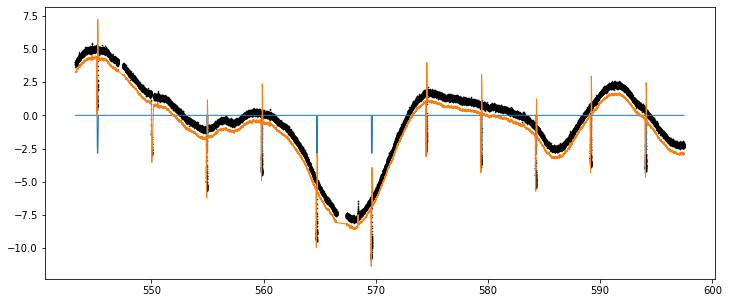

In [137]:
plt.figure(figsize=(12,5))
plt.plot(x, y, "k.", ms=1)

gp_mod = map_soln['gp_pred']+map_soln['mean']
transit_mod = map_soln['flux_model']

plt.plot(x, transit_mod, "C0-", lw=1)
plt.plot(x, gp_mod, "C1-", lw=1)

# plt.plot(x, transit_model_guess, "C2-", lw=1)

(-10.0, 2.0)

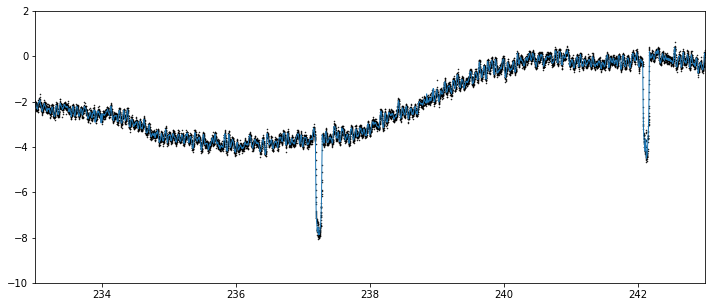

In [84]:
# Rodrigo
plt.figure(figsize=(12,5))
plt.plot(x, y, "k.", ms=1)

gp_mod = map_soln['gp_pred']#+map_soln['mean']
transit_mod = map_soln['flux_model']

plt.plot(x, transit_mod + gp_mod, "C0-", lw=1)
plt.xlim(233, 243)
plt.ylim(-10, 2)

In [55]:
# Rodrigo

map_soln["mean"]

array(0.0487469)

In [100]:
print('rp', map_soln["rp"])
print('u1', map_soln["u1"])
print('u2', map_soln["u2"])
print('period', map_soln['porb'])
print('t0', map_soln['t0'])

rp 0.03232377436812133
u1 0.6999622058195406
u2 0.049950888934601485
period 5.003162294158745
t0 124.81416882194266


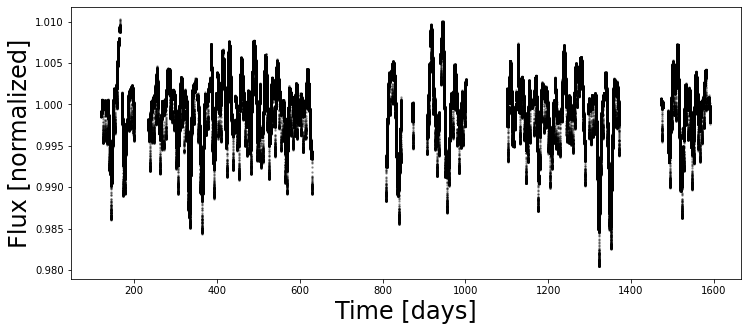

In [28]:
plt.figure(figsize=(12, 5))
plt.plot(all_lc.time.value, all_lc.flux.value, "k.", alpha=0.3, ms=3)
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

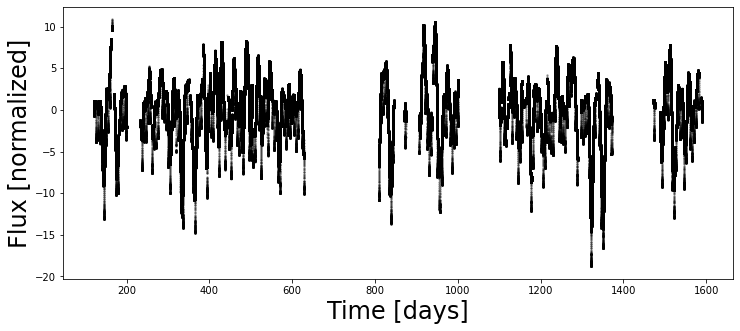

In [29]:
gp_mod = map_soln['gp_pred']+map_soln['mean']
plt.figure(figsize=(12, 5))
plt.plot(all_lc.time.value, gp_mod, "k.", alpha=0.3, ms=3)
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [30]:
gp_mod

array([-0.59045611, -0.60148496, -0.60530515, ..., -0.20611777,
       -0.71790749, -1.32548   ])

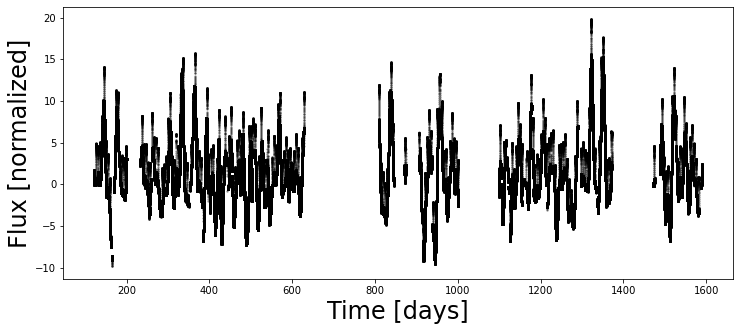

In [31]:
plt.figure(figsize=(12, 5))
plt.plot(all_lc.time.value, map_soln['flux_model'] - gp_mod, "k.", alpha=0.3, ms=3)
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

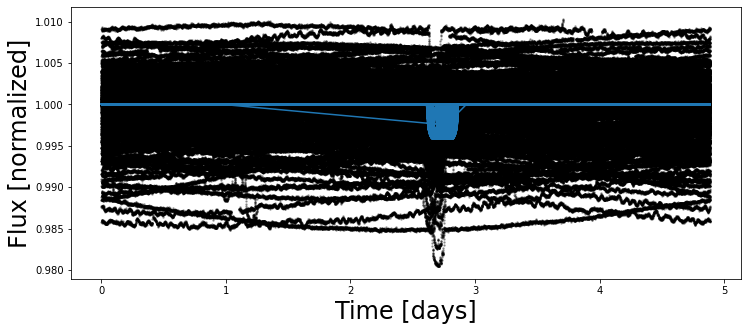

In [32]:
x = all_lc.time.value
y = all_lc.flux

x = np.sort(x)
y = y[np.argsort(x)]


plt.figure(figsize=(12, 5))
plt.plot(x%np.float64(planet_period), y, "k.", alpha=0.3, ms=3)
plt.plot(x%np.float64(planet_period), pmx.eval_in_model(model.flux_model, model=model))
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

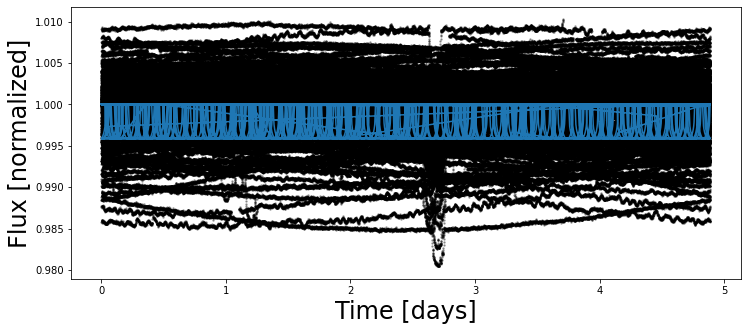

In [33]:
x = np.ascontiguousarray(all_lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(all_lc.flux, dtype=np.float64)

x = np.sort(x)
y = y[np.argsort(x)]


plt.figure(figsize=(12, 5))
plt.plot(x%np.float64(planet_period), y, "k.", alpha=0.3, ms=3)
plt.plot(x%np.float64(planet_period), map_soln['flux_model'])
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [34]:
starry.config.lazy = False
starry.config.quiet = True
A = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0)
A.map[1] = map_soln['u1']
A.map[2] = map_soln['u2']

b = starry.Secondary(
    starry.Map(ydeg=1, udeg=0, obl=0.0, amp=0),
    m=7.0257708e-5,  # mass in solar masses
    r=map_soln['rp'],  # radius in solar radii
    inc=88.99, # orbital inclination
    porb=map_soln['porb'],  # orbital period in days
    prot=1,
    w=-162.149,  # Argument of periastron (little omega)
    ecc=0.265,  # eccentricity
    Omega=106, # I think it's lambda in Morris 2017
    t0=map_soln['t0'],
)

sys = starry.System(A,b)

In [35]:
def starry_system(u1,u2,rp,porb,tzero):
    star = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0)
    star.map[1] = u1
    star.map[2] = u2

    planet_b = starry.Secondary(
        starry.Map(ydeg=1, udeg=0, amp=0),
        m=7.0257708e-5,  # mass in solar masses
        r=rp,  # radius in solar radii
        inc=88.99, # orbital inclination
        porb=porb,  # orbital period in days
        prot=1,
        w=-162.149,  # Argument of periastron (little omega)
        ecc=0.265,  # eccentricity
        Omega=106, # I think it's lambda in Morris 2017
        t0=tzero,
    )
    return starry.System(star,planet_b)


In [36]:
map_soln['flux_model'].min()

0.9958132516376104

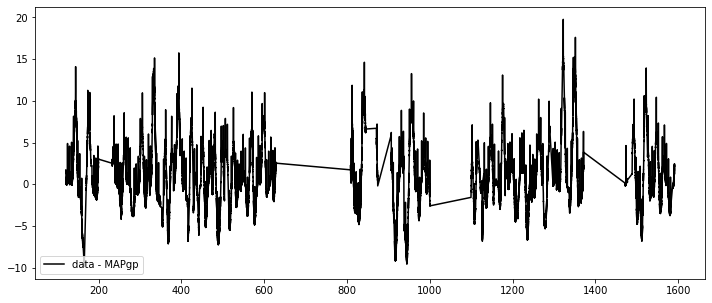

In [37]:
x = np.ascontiguousarray(all_lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(all_lc.flux, dtype=np.float64)

x = np.sort(x)
y = y[np.argsort(x)]

plt.figure(figsize=(12, 5))
plt.plot(x, y - gp_mod, "k", label="data - MAPgp")
plt.legend(fontsize=10, loc=3)

In [38]:
all_lc['time'].format = 'iso'
mask3 = [i.split('-')[0]=='2010' and i.split('-')[1]=='04' and i.split('-')[2].split(' ')[0]=='18' for i in all_lc['time'].value]
mask1 = [i.split('-')[0]=='2009' and i.split('-')[1]=='12' and i.split('-')[2].split(' ')[0]=='02' for i in all_lc['time'].value]
mask2 = [i.split('-')[0]=='2009' and i.split('-')[1]=='12' and i.split('-')[2].split(' ')[0]=='31' for i in all_lc['time'].value]
mask4 = [i.split('-')[0]=='2012' and i.split('-')[1]=='01' and i.split('-')[2].split(' ')[0]=='08' for i in all_lc['time'].value]
all_lc['time'].format = 'bkjd'
lc1 = all_lc[mask1]
lc2 = all_lc[mask2]
lc3 = all_lc[mask3]
lc4 = all_lc[mask4]
mask3 = np.zeros(len(lc3.flux), dtype=bool)
mask3[370:550] = 1
mask1 = np.zeros(len(lc1.flux), dtype=bool)
mask1[600:800] = 1
mask2 = np.zeros(len(lc2.flux), dtype=bool)
mask2[950:1150] = 1

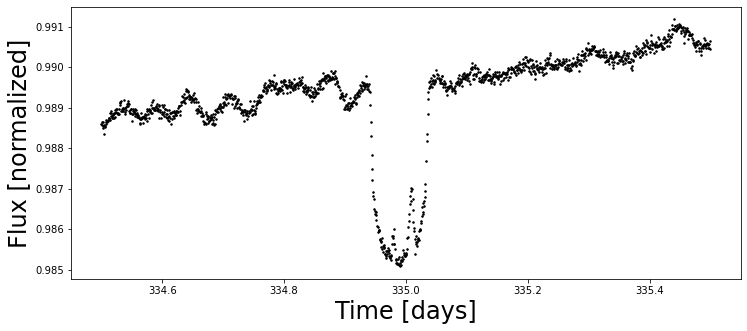

In [39]:
x = lc1.time.value
y = lc1.flux

plt.figure(figsize=(12, 5))
plt.plot(x, y, "k.", ms=3)
# plt.plot(x, sys.flux(x))
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);